### Implementing logistic regression from scratch

#### The goal of this project is to
- Implement logistic regression with gradiant descent from scratch 
- perform sentiment analysis on curated Amazon review data
- explore effects regularization with logistic regression 

The project is developed upon a project for classification class from UW on Coursera. 

A subset of the Amazon product review dataset is provided as class materials in csv format. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

#### Emma Yu, Sep 2016

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8., 10.0) 

First, let's read the data into a Pandas dataframe. There are 53072 rows and 4 columns of the data. Each row contains a review for a baby project on Amazon, and each row includes 

- the product name ('name')
- the review in original text form ('review')
- the customer rating ("rating", ranging from 1 to 5 with 5 being the highest)
- a label denoting whether the review is positive or negative ("sentiment", 1 means positive, and -1 means negative).


In [2]:
df = pd.read_csv('amazon_baby_subset.csv', skiprows =1, names = ['name','review','rating','sentiment']) 

In [3]:
df.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [4]:
print df.dtypes
print df.describe()

name         object
review       object
rating        int64
sentiment     int64
dtype: object
             rating     sentiment
count  53072.000000  53072.000000
mean       3.097490      0.001620
std        1.730509      1.000008
min        1.000000     -1.000000
25%        1.000000     -1.000000
50%        4.000000      1.000000
75%        5.000000      1.000000
max        5.000000      1.000000


In [5]:
print 'number of positive items: ',df[df.sentiment == 1].sentiment.count()
print 'number of negative items: ',df[df.sentiment == -1].sentiment.count()

number of positive items:  26579
number of negative items:  26493


We can see as described in the problem setup, the number of positive and negative items are about the same. 

The "sentiment" column is actually generated from "rating" in previous data cleaning processes. We removed neutral ratings (rating = 3), and decided to consider reviews with rating 1-2 as negative, and 4-5 as positive.

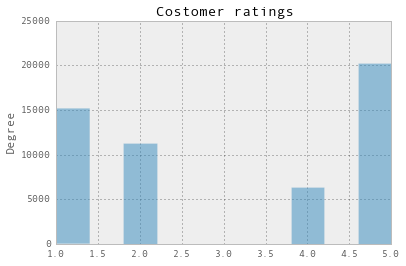

In [6]:
pd.options.display.mpl_style = 'default'
df['rating'].plot( x='Rating', y='Count', kind='hist', alpha=0.5, title='Costomer ratings')

### Data cleaning
Before we dive into the review data, let's first deal with some missing entreis (n/a), and remove functuation for the ease of further processing. 

In [7]:
# fill in nas in the review column
df = df.fillna({'review':''})  

In [8]:
# let's use pandas translate to map all punctuations into empty strings
import string
df['review_clean'] = df['review'].apply(lambda x: x.translate(string.maketrans("",""), string.punctuation))

In [9]:
# print the first 5 entries to make sure the puncutation has been successfully removed
df['review_clean'].iloc[0:5]

0    All of my kids have cried nonstop when I tried...
1    We wanted to get something to keep track of ou...
2    My daughter had her 1st baby over a year ago S...
3    One of babys first and favorite books and it i...
4    Very cute interactive book My son loves this b...
Name: review_clean, dtype: object

### Feature extraction
Let's build bag-of-words features for the 193 most frequent words (the list of words is provided for this assignment). 

In [10]:
# first read in the list of word from json file. 
import json
with open('important_words.json') as data_file:    
    important_words = json.load(data_file)

In [11]:
# print out the first 5 entries to check
important_words[0:5]

[u'baby', u'one', u'great', u'love', u'use']

In [12]:
# now let's do word counts for all the reviews
for word in important_words:
    df[word] = df['review_clean'].apply(lambda s : s.split().count(word))

In [13]:
# Now we should have one column for each word count. Let's check the dimension of the dataframe
# to confirm this.
df.shape

(53072, 198)

In [14]:
# Let's look at one word as an example, say, how many reviews contain the word perfect?
df['perfect'].apply(lambda count: 1 if count>0 else 0).sum()

2955

To make our later operations more efficient, let's convert our count data into a numpy array:

In [15]:
def get_numpy_data(dataframe, features, label):
    '''  
    Input: 
    dataframe - every row contains one data, and each feature is a column in the data frame
    features - a list of string of feature names
    lable - name of the class label column
    
    return
    - a 2D array contains the values for every feature and a column of 1 for fitting the intercept
    - a 1D array of the class values
    
    '''
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [16]:
feature_matrix, sentiment = get_numpy_data(df, important_words, 'sentiment')

In [17]:
feature_matrix.shape

(53072, 194)

In [18]:
sentiment.shape

(53072,)

### Construct the logistic regression model

In [142]:
def predict_probability(feature_matrix, coefficients):
    ''' 
    compute the probability of prediction 1s given feature matrix
    and coefficients with a logic link.
    
    return a vector - one probability for each data point
    '''
    
    score = np.dot(feature_matrix, coefficients)
    predictions = 1./(1.+np.exp(-score))
    return predictions

In [143]:
def feature_derivative(errors, feature):     
    ''' 
    Compute the derivative given a column of errors and a column of feature
    '''
    derivative = np.dot(errors, feature).sum()

    return derivative


In [144]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    ''' 
    Compute the log-likelihood function for logistic regression
    not sure about this one. need double check
    '''
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

In [145]:
def logistic_regression(feature_matrix, sentiment, init_coefficients, stepsize, max_iter):
    '''
    Do we actually need the likelihood function for anything?
    '''
    coeff = init_coefficients
    pred = predict_probability(feature_matrix, coeff)
    # let's figure out how to calculate the error 
    errors = (sentiment==+1)-pred
    #print 'total errors = ',np.sum(errors)
    
    for i in range(max_iter):
        totalpartial = 0
        for j in range(len(important_words)+1):
            # gredient ascent on one dimension
            partial = feature_derivative(errors, feature_matrix[:,j])
            coeff[j] += stepsize*partial
            totalpartial += partial**2
            # calculate the new prediction and error
            
        pred = predict_probability(feature_matrix, coeff)
        errors = (sentiment==+1)-pred
            
            # exit condition <- need some work
        if totalpartial <= 1e-5: 
            print 'exit after', i ,'iterations'
            return coeff, pred
        
    return coeff, pred

In [146]:
coeff, pred = logistic_regression(feature_matrix, sentiment, np.zeros(len(important_words)+1), 1e-7, 301)

(array([  1.,   4.,  11.,  60.,  82.,  27.,   4.,   0.,   2.,   3.]),
 array([-0.05386015, -0.04181953, -0.0297789 , -0.01773828, -0.00569766,
         0.00634297,  0.01838359,  0.03042421,  0.04246484,  0.05450546,
         0.06654608]),
 <a list of 10 Patch objects>)

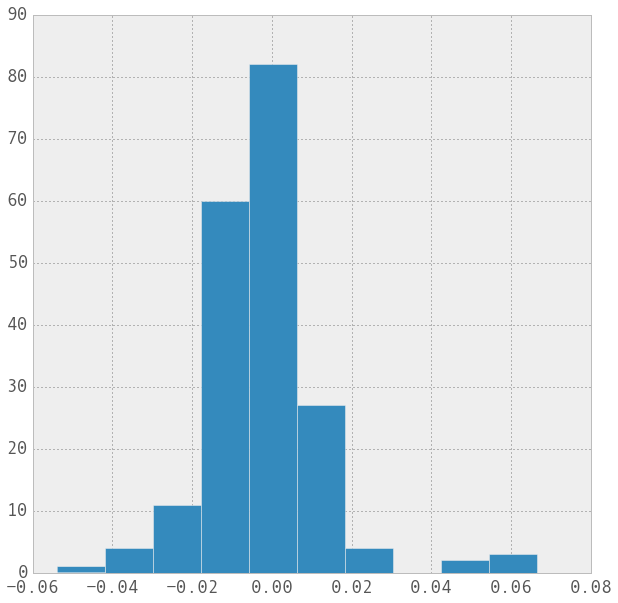

In [152]:
plt.hist(coeff)

In [153]:
def pred_accuracy(predprob, actual_y):
    # number of reviews that are predicted as positive
    pos = (predprob>=0.5)
    #print 'number of positives predicted ',np.sum(pos)

    # What about the accuracy?
    actualpos = (actual_y==+1)
    agree = (pos == actualpos)
    numagree = np.sum(agree)
    accuracy = (numagree +0.0)/agree.shape[0]
    
    #print 'number of correct predictions ', numagree
    #print 'accuracy ', accuracy
    
    return accuracy

In [154]:
pred_accuracy(pred, sentiment)

0.7518653904130238

In [155]:
# Let's sort the word list by weight
sindex = coeff.argsort()
# note that the weight array includes the intercept. Let's add an empty string to count for that.
full_words = np.array([' '] +important_words) 
sorted_words = full_words[sindex]

In [156]:
# print the top 10 negative words
#sorted_words[0:10]
#sorted_words[-10:]

def plot_top_words(num, twords, wprob, title):
    matplotlib.rcParams['figure.figsize'] = (12, 8.0) 
    plt.bar(range(num), wprob, 0.6)
    plt.xticks(range(num), twords)
    plt.tick_params(labelsize=15)
    plt.title(title, fontsize=20)
    plt.show()


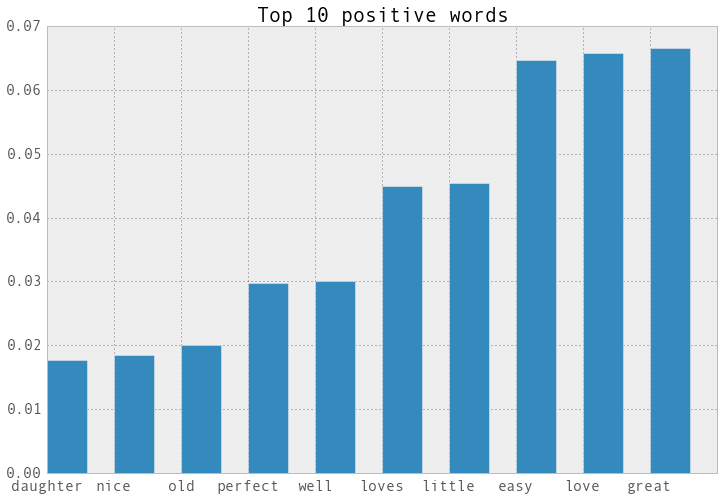

In [157]:
plot_top_words(10, sorted_words[-10:], coeff[sindex][-10:],'Top 10 positive words')

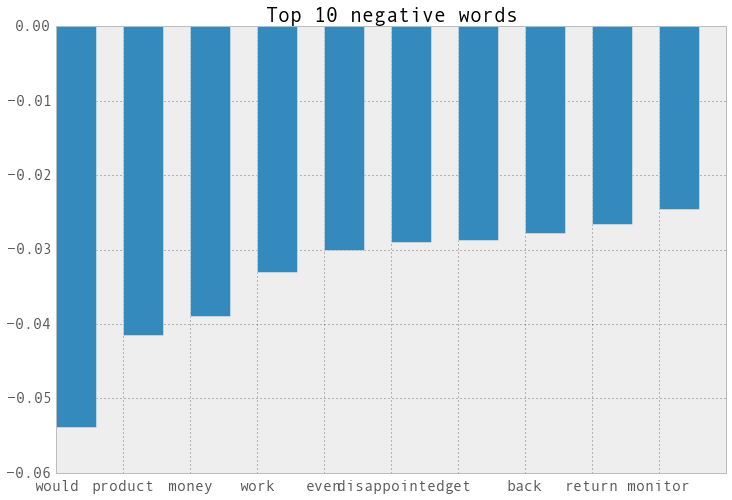

In [158]:
plot_top_words(10, sorted_words[0:10], coeff[sindex][0:10],'Top 10 negative words')

### Now let's add some regularization to prevent over-fitting

Let's separate the dataset into training and validation set in order to select model parameters.

In [163]:
# For the purpose of testing result, we split training and validation set based on give indices.

with open('module-4-assignment-train-idx.json') as data:    
    train_idx = json.load(data)
    
with open('module-4-assignment-validation-idx.json') as data:    
    valid_idx = json.load(data)

In [164]:
train = df.iloc[train_idx,:]
valid = df.iloc[valid_idx,:]

print train.shape
print valid.shape

(42361, 199)
(10711, 199)


In [165]:
feature_train, sentiment_train = get_numpy_data(train, important_words, 'sentiment')
feature_valid, sentiment_valid = get_numpy_data(valid, important_words, 'sentiment')

/Users/emmayu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [166]:
def logistic_regression_L2(feature_matrix, sentiment, init_coefficients, stepsize, l2_penalty, max_iter):
    '''
    Note that we do not put penalty on the intercept
    The first coefficient is for the intercept
    '''
    coeff = init_coefficients
    pred = predict_probability(feature_matrix, coeff)
    # let's figure out how to calculate the error 
    errors = (sentiment==+1)-pred
    #print 'total errors = ',np.sum(errors)
    
    for i in range(max_iter):
        totalpartial = 0
        for j in range(len(important_words)+1):
            # gredient ascent on one dimension
            partial = feature_derivative(errors, feature_matrix[:,j])
            if j == 0:
                coeff[j] += stepsize*partial    
            else:
                coeff[j] += stepsize*(partial - 2*l2_penalty*coeff[j])
                
            totalpartial += partial**2
            # calculate the new prediction and error
            
        pred = predict_probability(feature_matrix, coeff)
        errors = (sentiment==+1)-pred
            
            # exit condition <- need some work
        if totalpartial <= 1e-5: 
            print 'exit after', i ,'iterations'
            return coeff, pred
        
    return coeff, pred

In [167]:
def train_n_valid_l2(stepsize, l2_penalty, max_iter):
    '''
    calculating the accuracies on training and validation sets
    for the logistic regression model with L2 penalty
    return accuracies, predictions, and the coefficients
    '''
    #print 'for training data:'
    coeff_train, pred_train =logistic_regression_L2(feature_train, sentiment_train, np.zeros(len(important_words)+1),stepsize, l2_penalty, max_iter)
    # calculate the training accuracy 
    train_accuracy = pred_accuracy(pred_train, sentiment_train)
    # predict validation set and plot the accuracy
    #print 'for validation data:'
    pred_valid = predict_probability(feature_valid, coeff_train)
    valid_accuracy = pred_accuracy(pred_valid, sentiment_valid)
    
    #print 'train accuracy = ', train_accuracy
    #print 'test accuracy = ', test_accuracy
    return coeff_train, pred_train, pred_valid, train_accuracy, valid_accuracy

In [168]:
l2s = [0, 4, 10, 1e2, 1e3, 1e5]
print len(important_words)

193


In [169]:
# let's do a grid search and see how coefficients and accuracies change with L2 regularization.

l2s = [0, 4, 10, 1e2, 1e3, 1e5]
coeffs = np.zeros([len(important_words)+1,len(l2s)])
pred_train = np.zeros([sentiment_train.shape[0],len(l2s)])
pred_valid = np.zeros([sentiment_valid.shape[0],len(l2s)])
train_acuracy = np.zeros([len(l2s)])
valid_acuracy = np.zeros([len(l2s)])

In [170]:
for i, val in enumerate(l2s):
    (coeffs[:,i], pred_train[:,i], pred_valid[:,i], train_acuracy[i], valid_acuracy[i]) = train_n_valid_l2(5e-6, val, 501)

In [171]:
print train_acuracy
print valid_acuracy

[ 0.78515616  0.78510894  0.78499091  0.78397583  0.77585515  0.68036637]
[ 0.78143964  0.781533    0.78171973  0.78106619  0.77135655  0.66781813]


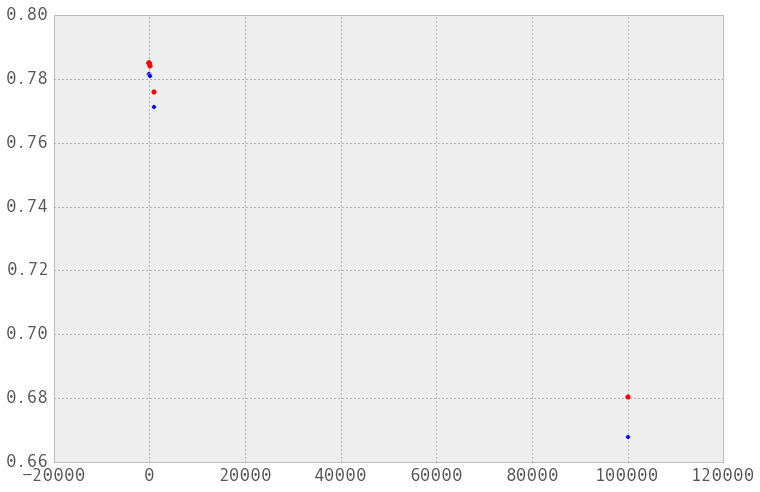

In [172]:
plt.scatter(l2s, train_acuracy, color='r')
plt.scatter(l2s, valid_acuracy)

In [173]:
# Let's extract the coefficients for important words in the no regularization case:
index = coeffs[:,0].argsort()
# note that the weight array includes the intercept. Let's add an empty string to count for that.
full_words = np.array([' '] +important_words) 
bad_words = full_words[index[:10]]
good_words = full_words[index[-10:]]

good_coeffs = coeffs[index[:10],:]
bad_coeffs = coeffs[index[-10:],:]

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

def make_coefficient_plot(positivecoeff, negativecoeff, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = positivecoeff
    table_negative_words = negativecoeff

    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


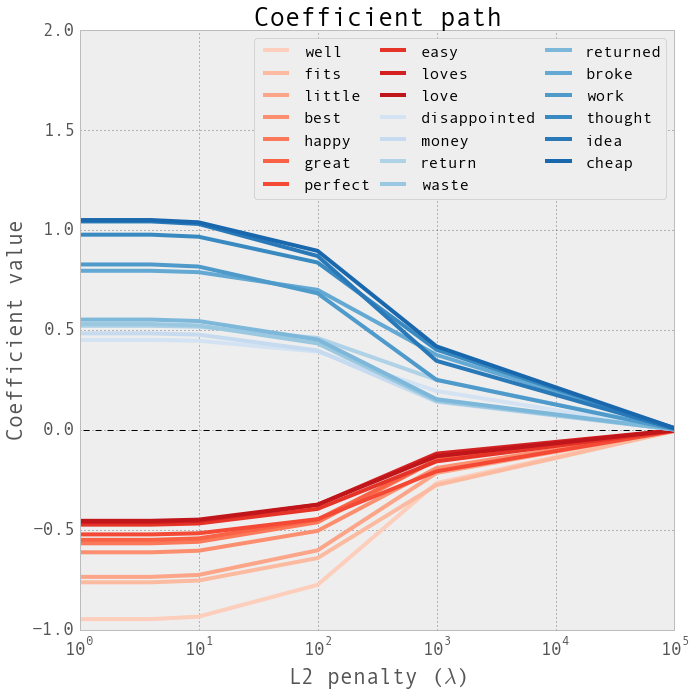

In [175]:
make_coefficient_plot(good_coeffs, bad_coeffs,good_words, bad_words, l2s)

We can see the coefficients keep decreasing as we increase the level of L2 regularization. However the relative importance of variables can change as we change the regularization. Zero regularization provides the best training accuracy, but the model with lambda = 10 provides the best accuracy on the validation data. 